# Linear quantum photonic circuits as Gaussian kernel samplers

The goal of this notebook is to reproduce the quantum photonic circuit as a Gaussian kernel sampler from [Fock State-enhanced Expressivity of Quantum Machine Learning Models](https://arxiv.org/abs/2107.05224) and analyse its expressive power based on the number of photon used. That corresponds to the second algorithm showcased by this paper. Then, we will use our trained circuit for a classification task by feeding the approximated similarity matrix to a Support Vector Machine (SVM).

To train our circuit, we will use [MerLin](https://merlinquantum.ai/index.html) which applies the gradient descent algorithm and allows the usage of quantum components mixed with PyTorch structures to build and optimize a hybrid model.

## 0. Imports and prep

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import perceval as pcvl
import torch
import torch.nn as nn
from matplotlib.patches import Patch
from merlin import OutputMappingStrategy, QuantumLayer
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm

## 1. Define input data : delta (squared Euclidean distance between x and zero)

In [ ]:
# We want x form -pi to pi
x = np.linspace(-np.pi, np.pi, num=int(2 * np.pi / 0.05) + 1)
# We will use x_on_pi for visualization
x_on_pi = x / np.pi
# delta will be the input to our quantum model
delta = (x - 0) ** 2


def target_function(delta, sigma=1.0):
    return np.exp(-delta / (2 * sigma * sigma))


gauss_025 = target_function(delta, sigma=0.25)
gauss_033 = target_function(delta, sigma=0.33)
gauss_050 = target_function(delta, sigma=0.50)
gauss_100 = target_function(delta, sigma=1.00)

Let's visualize our different Gaussians that our model will fit.

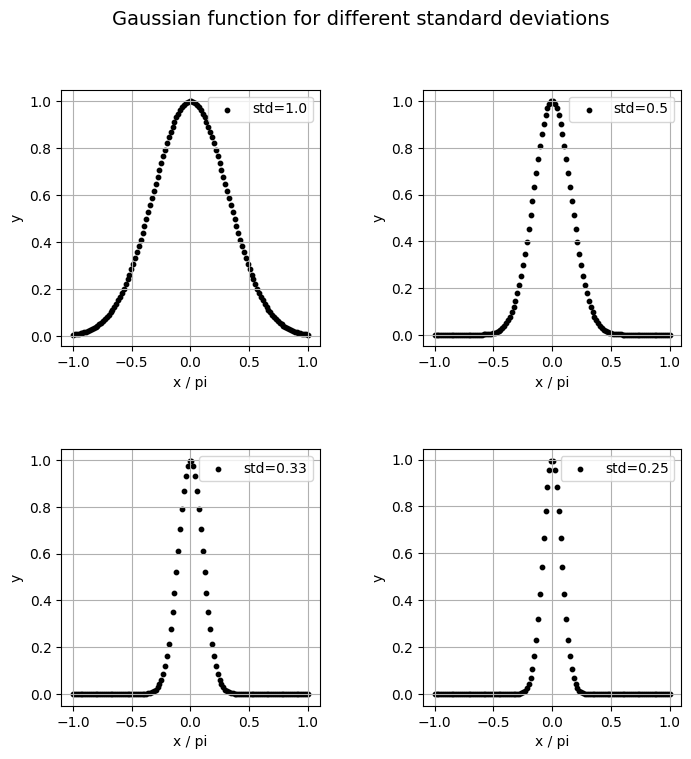

<Figure size 640x480 with 0 Axes>

In [3]:
# Plot using matplotlib
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
i = 0
j = 0
ys = [gauss_025, gauss_033, gauss_050, gauss_100]
ys = list(reversed(ys))
sigmas = [0.25, 0.33, 0.50, 1.00]
sigmas = list(reversed(sigmas))

for y, sigma in zip(ys, sigmas):
    axis = axs[i // 2][j % 2]
    axis.scatter(x_on_pi, y, label=f"std={sigma}", s=10, color="k")
    axis.set_xlabel("x / pi")
    axis.set_ylabel("y")
    axis.grid(True)
    axis.legend(loc="upper right")
    i += 1
    j += 1

fig.suptitle("Gaussian function for different standard deviations", fontsize=14)
plt.show()
plt.clf()

## 2. Model definition

First, we have to build the quantum circuit that we will use in the model with the help of [Perceval](https://perceval.quandela.net). In the reference paper, the circuit used is a simple Mach-Zehnder interferometer (MZI) which is a popular circuit in QML. However, let's define a general circuit with more trainable parameters that yields better results in our case.

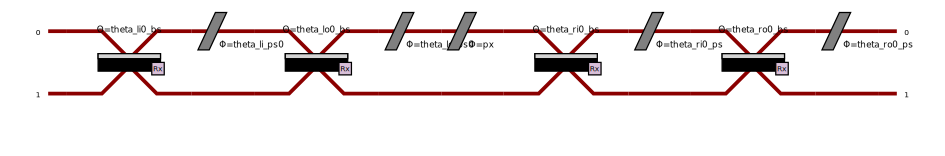

In [4]:
def create_circuit_general():
    """Create variational quantum classifier with specified number of modes using general meshes"""

    wl = pcvl.GenericInterferometer(
        2,
        lambda i: pcvl.BS(pcvl.P(f"theta_li{i}_bs"))
        // pcvl.PS(pcvl.P(f"theta_li_ps{i}"))
        // pcvl.BS(pcvl.P(f"theta_lo{i}_bs"))
        // pcvl.PS(pcvl.P(f"theta_lo_ps{i}")),
        shape=pcvl.InterferometerShape.RECTANGLE,
    )

    c_var = pcvl.Circuit(2)
    px = pcvl.P("px")
    c_var.add(0, pcvl.PS(px))

    wr = pcvl.GenericInterferometer(
        2,
        lambda i: pcvl.BS(pcvl.P(f"theta_ri{i}_bs"))
        // pcvl.PS(pcvl.P(f"theta_ri{i}_ps"))
        // pcvl.BS(pcvl.P(f"theta_ro{i}_bs"))
        // pcvl.PS(pcvl.P(f"theta_ro{i}_ps")),
        shape=pcvl.InterferometerShape.RECTANGLE,
    )

    c = pcvl.Circuit(2)
    c.add(0, wl, merge=True)
    c.add(0, c_var, merge=True)
    c.add(0, wr, merge=True)

    return c


def count_parameters(model):
    """Count trainable parameters in a PyTorch model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Visualize general circuit
example_circuit = create_circuit_general()
pcvl.pdisplay(example_circuit)

Second, we also need to define a scaling layer that simply multiplies the input by a constant before encoding it in the circuit. That will be the first layer of our model.

In [5]:
class ScaleLayer(nn.Module):
    """
    Multiply the input tensor by a learned or fixed factor.

    Args:
        dim (int): Dimension of the input data to be encoded.
        scale_type (str): Type of scaling method.

    Returns: nn.Module that multiplies the input tensor by a learned or fixed factor.
    """

    def __init__(self, dim, scale_type="learned"):
        super().__init__()
        # Create a single learnable parameter (initialized to 0.1 by default)
        if scale_type == "learned":
            self.scale = nn.Parameter(torch.full((dim,), 0.1))
        elif scale_type == "2pi":
            self.scale = torch.full((dim,), 2 * torch.pi)
        elif scale_type == "pi":
            self.scale = torch.full((dim,), torch.pi)
        elif scale_type == "/pi":
            self.scale = torch.full((dim,), 1 / torch.pi)
        elif scale_type == "1":
            self.scale = torch.full((dim,), 1)
        elif scale_type == "0.1":
            self.scale = torch.full((dim,), 0.1)
        elif scale_type == "/2pi":
            self.scale = torch.full((dim,), 1 / (2 * torch.pi))

    def forward(self, x):
        # Element-wise multiplication of each input element by the learned scale
        return x * self.scale

Then, we use MerLin to define the quantum layer that we will use to build our hybrid model. MerLin allows the optimization of the quantum components to run smoothly using the efficient PyTorch framework.

In our specific case, we will determine the input state of the circuit depending on the number of photons.

In [6]:
def create_quantum_layer(num_photons):
    """Create a quantum layer consisting of a VQC for a specific initial state"""
    if num_photons % 2 == 0:
        input_state = [num_photons // 2, num_photons // 2]
    else:
        input_state = [(num_photons // 2) + 1, num_photons // 2]

    trainable_params = ["theta"]
    circuit = create_circuit_general()

    scale_layer = ScaleLayer(1, "learned")

    vqc = QuantumLayer(
        input_size=1,
        output_size=1,
        circuit=circuit,
        trainable_parameters=trainable_params,
        input_parameters=["px"],
        input_state=input_state,
        no_bunching=False,
        output_mapping_strategy=OutputMappingStrategy.LINEAR,
    )

    model = nn.Sequential(scale_layer, vqc)

    return model


# Let's create some MZI circuits to see their number of parameters and their input state
vqc_2_photons = create_quantum_layer(2)
vqc_4_photons = create_quantum_layer(4)
vqc_6_photons = create_quantum_layer(6)
vqc_8_photons = create_quantum_layer(8)
vqc_10_photons = create_quantum_layer(10)

models = {
    "VQC 2": vqc_2_photons,
    "VQC 4": vqc_4_photons,
    "VQC 6": vqc_6_photons,
    "VQC 8": vqc_8_photons,
    "VQC 10": vqc_10_photons,
}

for name, model in models.items():
    input_state = model[1].input_state
    print(
        f"{name}: {count_parameters(model)} parameters and input Fock state {input_state}"
    )

VQC 2: 13 parameters and input Fock state [1, 1]
VQC 4: 15 parameters and input Fock state [2, 2]
VQC 6: 17 parameters and input Fock state [3, 3]
VQC 8: 19 parameters and input Fock state [4, 4]
VQC 10: 21 parameters and input Fock state [5, 5]


## 3. Training function

Thanks to MerLin, the optimization of the model has the same programing structure as PyTorch with classical methods.

In [7]:
def train_model(model, x_train, y_train, model_name):
    """Train a model and return training metrics"""
    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.02, betas=(0.7, 0.9), weight_decay=0
    )
    criterion = nn.MSELoss()

    losses = []
    train_mses = []

    model.train()

    pbar = tqdm(range(200), desc=f"Training {model_name}")
    for _epoch in pbar:
        permutation = torch.randperm(x_train.size()[0])
        total_loss = 0

        for i in range(0, x_train.size()[0], 32):
            indices = permutation[i : i + 32]
            batch_x, batch_y = x_train[indices], y_train[indices]

            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y.squeeze())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / (x_train.size()[0] // 32)
        losses.append(avg_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            train_outputs = model(x_train)
            train_mse = mean_squared_error(y_train.numpy(), train_outputs)
            train_mses.append(train_mse)

            pbar.set_description(
                f"Training {model_name} - Loss: {avg_loss:.4f}, Train MSE: {train_mse:.4f}"
            )

        model.train()

    return {
        "losses": losses,
        "train_mses": train_mses,
    }

In [8]:
def train_models_multiple_runs(num_photons, colors, x_train, ys_info):
    """Train all models multiple times and return results"""
    all_results = {}
    ys = ys_info["ys"]
    names = ys_info["names"]

    assert names[0] == "std = 1.00"

    for y, name in zip(ys, names):
        results = {}
        models = []
        for n, color in zip(num_photons, colors):
            print(
                f"\nTraining MZI with {n} photons ({3} runs) for Gaussian with {name}:"
            )
            best_model = None
            best_final_train_mse = np.inf
            model_runs = []

            for run in range(3):
                # Create a fresh instance of the model for each run
                qmodel = create_quantum_layer(n)

                print(f"  Run {run + 1}/{3}...")
                run_results = train_model(
                    qmodel,
                    torch.tensor(x_train, dtype=torch.float).unsqueeze(-1),
                    torch.tensor(y, dtype=torch.float),
                    f"MZI_{n}-run{run + 1}",
                )

                model_runs.append(run_results)
                if run_results["train_mses"][-1] < best_final_train_mse:
                    best_final_train_mse = run_results["train_mses"][-1]
                    best_model = qmodel

            models.append(best_model)
            # Store all runs for this model
            results[f"MZI_{n}"] = {
                "runs": model_runs,
                "color": color,
            }
        all_results[f"{name}"] = {
            "results": results,
            "models": models,
        }

    return all_results

In [9]:
# Training set-up
num_photons = [2, 4, 6, 8, 10]
colors = ["blue", "orange", "green", "red", "purple"]
std_names = ["std = 1.00", "std = 0.50", "std = 0.33", "std = 0.25"]
ys_info = {"ys": ys, "names": std_names}

# Train all models
all_results = train_models_multiple_runs(num_photons, colors, delta, ys_info)


Training MZI with 2 photons (3 runs) for Gaussian with std = 1.00:
  Run 1/3...


Training MZI_2-run1 - Loss: 0.0011, Train MSE: 0.0011: 100%|██████████| 200/200 [00:01<00:00, 168.54it/s]


  Run 2/3...


Training MZI_2-run2 - Loss: 0.0136, Train MSE: 0.0087: 100%|██████████| 200/200 [00:01<00:00, 173.37it/s]


  Run 3/3...


Training MZI_2-run3 - Loss: 0.0012, Train MSE: 0.0009: 100%|██████████| 200/200 [00:01<00:00, 177.07it/s]



Training MZI with 4 photons (3 runs) for Gaussian with std = 1.00:
  Run 1/3...


Training MZI_4-run1 - Loss: 0.0029, Train MSE: 0.0025: 100%|██████████| 200/200 [00:01<00:00, 167.66it/s]


  Run 2/3...


Training MZI_4-run2 - Loss: 0.0011, Train MSE: 0.0006: 100%|██████████| 200/200 [00:01<00:00, 168.16it/s]


  Run 3/3...


Training MZI_4-run3 - Loss: 0.0008, Train MSE: 0.0005: 100%|██████████| 200/200 [00:01<00:00, 163.14it/s]



Training MZI with 6 photons (3 runs) for Gaussian with std = 1.00:
  Run 1/3...


Training MZI_6-run1 - Loss: 0.0027, Train MSE: 0.0012: 100%|██████████| 200/200 [00:01<00:00, 160.94it/s]


  Run 2/3...


Training MZI_6-run2 - Loss: 0.0106, Train MSE: 0.0029: 100%|██████████| 200/200 [00:01<00:00, 153.42it/s]


  Run 3/3...


Training MZI_6-run3 - Loss: 0.0034, Train MSE: 0.0026: 100%|██████████| 200/200 [00:01<00:00, 152.09it/s]



Training MZI with 8 photons (3 runs) for Gaussian with std = 1.00:
  Run 1/3...


Training MZI_8-run1 - Loss: 0.0008, Train MSE: 0.0007: 100%|██████████| 200/200 [00:01<00:00, 144.56it/s]


  Run 2/3...


Training MZI_8-run2 - Loss: 0.0005, Train MSE: 0.0002: 100%|██████████| 200/200 [00:01<00:00, 123.25it/s]


  Run 3/3...


Training MZI_8-run3 - Loss: 0.0055, Train MSE: 0.0017: 100%|██████████| 200/200 [00:01<00:00, 117.57it/s]



Training MZI with 10 photons (3 runs) for Gaussian with std = 1.00:
  Run 1/3...


Training MZI_10-run1 - Loss: 0.0045, Train MSE: 0.0038: 100%|██████████| 200/200 [00:01<00:00, 108.61it/s]


  Run 2/3...


Training MZI_10-run2 - Loss: 0.0002, Train MSE: 0.0001: 100%|██████████| 200/200 [00:01<00:00, 129.31it/s]


  Run 3/3...


Training MZI_10-run3 - Loss: 0.0064, Train MSE: 0.0020: 100%|██████████| 200/200 [00:01<00:00, 126.06it/s]



Training MZI with 2 photons (3 runs) for Gaussian with std = 0.50:
  Run 1/3...


Training MZI_2-run1 - Loss: 0.0594, Train MSE: 0.0354: 100%|██████████| 200/200 [00:01<00:00, 153.17it/s]


  Run 2/3...


Training MZI_2-run2 - Loss: 0.0881, Train MSE: 0.0648: 100%|██████████| 200/200 [00:01<00:00, 153.37it/s]


  Run 3/3...


Training MZI_2-run3 - Loss: 0.0170, Train MSE: 0.0114: 100%|██████████| 200/200 [00:01<00:00, 151.19it/s]



Training MZI with 4 photons (3 runs) for Gaussian with std = 0.50:
  Run 1/3...


Training MZI_4-run1 - Loss: 0.0259, Train MSE: 0.0158: 100%|██████████| 200/200 [00:01<00:00, 142.62it/s]


  Run 2/3...


Training MZI_4-run2 - Loss: 0.0037, Train MSE: 0.0013: 100%|██████████| 200/200 [00:01<00:00, 145.20it/s]


  Run 3/3...


Training MZI_4-run3 - Loss: 0.0317, Train MSE: 0.0216: 100%|██████████| 200/200 [00:01<00:00, 147.87it/s]



Training MZI with 6 photons (3 runs) for Gaussian with std = 0.50:
  Run 1/3...


Training MZI_6-run1 - Loss: 0.0010, Train MSE: 0.0006: 100%|██████████| 200/200 [00:01<00:00, 133.47it/s]


  Run 2/3...


Training MZI_6-run2 - Loss: 0.0358, Train MSE: 0.0190: 100%|██████████| 200/200 [00:01<00:00, 140.90it/s]


  Run 3/3...


Training MZI_6-run3 - Loss: 0.0216, Train MSE: 0.0112: 100%|██████████| 200/200 [00:01<00:00, 139.67it/s]



Training MZI with 8 photons (3 runs) for Gaussian with std = 0.50:
  Run 1/3...


Training MZI_8-run1 - Loss: 0.0037, Train MSE: 0.0031: 100%|██████████| 200/200 [00:01<00:00, 129.76it/s]


  Run 2/3...


Training MZI_8-run2 - Loss: 0.0089, Train MSE: 0.0048: 100%|██████████| 200/200 [00:01<00:00, 124.98it/s]


  Run 3/3...


Training MZI_8-run3 - Loss: 0.0013, Train MSE: 0.0006: 100%|██████████| 200/200 [00:01<00:00, 130.68it/s]



Training MZI with 10 photons (3 runs) for Gaussian with std = 0.50:
  Run 1/3...


Training MZI_10-run1 - Loss: 0.0104, Train MSE: 0.0113: 100%|██████████| 200/200 [00:01<00:00, 127.43it/s]


  Run 2/3...


Training MZI_10-run2 - Loss: 0.0002, Train MSE: 0.0001: 100%|██████████| 200/200 [00:01<00:00, 125.06it/s]


  Run 3/3...


Training MZI_10-run3 - Loss: 0.0008, Train MSE: 0.0004: 100%|██████████| 200/200 [00:01<00:00, 129.99it/s]



Training MZI with 2 photons (3 runs) for Gaussian with std = 0.33:
  Run 1/3...


Training MZI_2-run1 - Loss: 0.0589, Train MSE: 0.0436: 100%|██████████| 200/200 [00:01<00:00, 150.98it/s]


  Run 2/3...


Training MZI_2-run2 - Loss: 0.0333, Train MSE: 0.0217: 100%|██████████| 200/200 [00:01<00:00, 145.43it/s]


  Run 3/3...


Training MZI_2-run3 - Loss: 0.0569, Train MSE: 0.0452: 100%|██████████| 200/200 [00:01<00:00, 126.10it/s]



Training MZI with 4 photons (3 runs) for Gaussian with std = 0.33:
  Run 1/3...


Training MZI_4-run1 - Loss: 0.0367, Train MSE: 0.0263: 100%|██████████| 200/200 [00:01<00:00, 147.92it/s]


  Run 2/3...


Training MZI_4-run2 - Loss: 0.0364, Train MSE: 0.0285: 100%|██████████| 200/200 [00:01<00:00, 145.08it/s]


  Run 3/3...


Training MZI_4-run3 - Loss: 0.0352, Train MSE: 0.0259: 100%|██████████| 200/200 [00:01<00:00, 145.43it/s]



Training MZI with 6 photons (3 runs) for Gaussian with std = 0.33:
  Run 1/3...


Training MZI_6-run1 - Loss: 0.0315, Train MSE: 0.0227: 100%|██████████| 200/200 [00:01<00:00, 134.69it/s]


  Run 2/3...


Training MZI_6-run2 - Loss: 0.0411, Train MSE: 0.0290: 100%|██████████| 200/200 [00:01<00:00, 140.43it/s]


  Run 3/3...


Training MZI_6-run3 - Loss: 0.0215, Train MSE: 0.0164: 100%|██████████| 200/200 [00:01<00:00, 137.07it/s]



Training MZI with 8 photons (3 runs) for Gaussian with std = 0.33:
  Run 1/3...


Training MZI_8-run1 - Loss: 0.0193, Train MSE: 0.0135: 100%|██████████| 200/200 [00:01<00:00, 128.31it/s]


  Run 2/3...


Training MZI_8-run2 - Loss: 0.0373, Train MSE: 0.0256: 100%|██████████| 200/200 [00:01<00:00, 134.65it/s]


  Run 3/3...


Training MZI_8-run3 - Loss: 0.0302, Train MSE: 0.0234: 100%|██████████| 200/200 [00:01<00:00, 133.78it/s]



Training MZI with 10 photons (3 runs) for Gaussian with std = 0.33:
  Run 1/3...


Training MZI_10-run1 - Loss: 0.0327, Train MSE: 0.0121: 100%|██████████| 200/200 [00:01<00:00, 130.37it/s]


  Run 2/3...


Training MZI_10-run2 - Loss: 0.0094, Train MSE: 0.0080: 100%|██████████| 200/200 [00:01<00:00, 130.56it/s]


  Run 3/3...


Training MZI_10-run3 - Loss: 0.0049, Train MSE: 0.0039: 100%|██████████| 200/200 [00:01<00:00, 131.69it/s]



Training MZI with 2 photons (3 runs) for Gaussian with std = 0.25:
  Run 1/3...


Training MZI_2-run1 - Loss: 0.0593, Train MSE: 0.0449: 100%|██████████| 200/200 [00:01<00:00, 153.13it/s]


  Run 2/3...


Training MZI_2-run2 - Loss: 0.0424, Train MSE: 0.0292: 100%|██████████| 200/200 [00:01<00:00, 154.37it/s]


  Run 3/3...


Training MZI_2-run3 - Loss: 0.0507, Train MSE: 0.0288: 100%|██████████| 200/200 [00:01<00:00, 153.45it/s]



Training MZI with 4 photons (3 runs) for Gaussian with std = 0.25:
  Run 1/3...


Training MZI_4-run1 - Loss: 0.0383, Train MSE: 0.0288: 100%|██████████| 200/200 [00:01<00:00, 140.90it/s]


  Run 2/3...


Training MZI_4-run2 - Loss: 0.0395, Train MSE: 0.0267: 100%|██████████| 200/200 [00:01<00:00, 150.84it/s]


  Run 3/3...


Training MZI_4-run3 - Loss: 0.0635, Train MSE: 0.0466: 100%|██████████| 200/200 [00:01<00:00, 143.30it/s]



Training MZI with 6 photons (3 runs) for Gaussian with std = 0.25:
  Run 1/3...


Training MZI_6-run1 - Loss: 0.0280, Train MSE: 0.0214: 100%|██████████| 200/200 [00:01<00:00, 146.26it/s]


  Run 2/3...


Training MZI_6-run2 - Loss: 0.0570, Train MSE: 0.0447: 100%|██████████| 200/200 [00:01<00:00, 136.74it/s]


  Run 3/3...


Training MZI_6-run3 - Loss: 0.0175, Train MSE: 0.0132: 100%|██████████| 200/200 [00:01<00:00, 141.35it/s]



Training MZI with 8 photons (3 runs) for Gaussian with std = 0.25:
  Run 1/3...


Training MZI_8-run1 - Loss: 0.0248, Train MSE: 0.0213: 100%|██████████| 200/200 [00:01<00:00, 137.53it/s]


  Run 2/3...


Training MZI_8-run2 - Loss: 0.0294, Train MSE: 0.0227: 100%|██████████| 200/200 [00:01<00:00, 132.97it/s]


  Run 3/3...


Training MZI_8-run3 - Loss: 0.0571, Train MSE: 0.0424: 100%|██████████| 200/200 [00:01<00:00, 134.62it/s]



Training MZI with 10 photons (3 runs) for Gaussian with std = 0.25:
  Run 1/3...


Training MZI_10-run1 - Loss: 0.0197, Train MSE: 0.0142: 100%|██████████| 200/200 [00:01<00:00, 119.30it/s]


  Run 2/3...


Training MZI_10-run2 - Loss: 0.0056, Train MSE: 0.0058: 100%|██████████| 200/200 [00:01<00:00, 130.15it/s]


  Run 3/3...


Training MZI_10-run3 - Loss: 0.0530, Train MSE: 0.0353: 100%|██████████| 200/200 [00:01<00:00, 121.33it/s]


## 4. Plot training loss

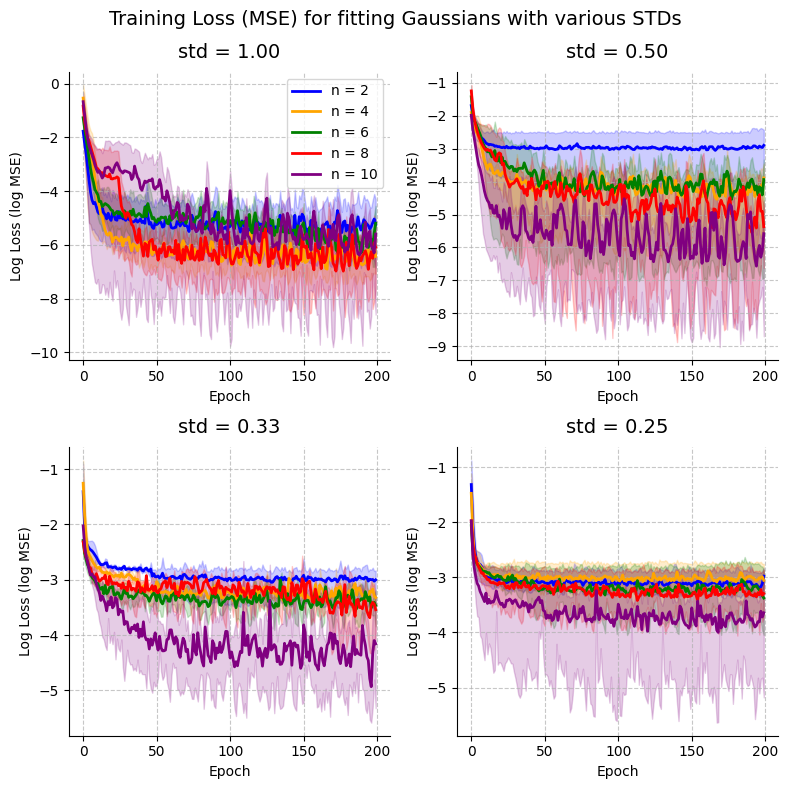

<Figure size 640x480 with 0 Axes>

In [10]:
def plot_training_curves(all_results):
    """Plot training curves for all model variants with average and envelope (only loss shown)"""
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    i = 0
    j = 0

    for y_name, results in all_results.items():
        axis = axs[i // 2, j % 2]
        # Plot each metric
        for model_name, model_data in results["results"].items():
            color = model_data["color"]
            linestyle = "-"

            # Get data from all runs
            losses_runs = [run["losses"] for run in model_data["runs"]]

            # Calculate mean values across all runs
            epochs = len(losses_runs[0])
            mean_losses = np.log(
                [
                    sum(run[i] for run in losses_runs) / len(losses_runs)
                    for i in range(epochs)
                ]
            )

            # Calculate min and max values for the envelope
            min_losses = np.log(
                [min(run[i] for run in losses_runs) for i in range(epochs)]
            )
            max_losses = np.log(
                [max(run[i] for run in losses_runs) for i in range(epochs)]
            )

            # Plot mean line
            axis.plot(
                mean_losses,
                label=f"n = {model_name[4:]}",
                color=color,
                linestyle=linestyle,
                linewidth=2,
            )

            # Plot envelope
            axis.fill_between(
                range(epochs), min_losses, max_losses, color=color, alpha=0.2
            )

        # Customize plot
        axis.set_title(f"{y_name}", fontsize=14, pad=10)
        axis.set_xlabel("Epoch")
        axis.set_ylabel("Log Loss (log MSE)")
        if i == 0 and j == 0:
            axis.legend()
        axis.grid(True, linestyle="--", alpha=0.7)
        axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)
        i += 1
        j += 1

    fig.suptitle(
        "Training Loss (MSE) for fitting Gaussians with various STDs", fontsize=14
    )
    plt.tight_layout()
    # plt.savefig("./results/training_curves_gaussian_kernels.png")  # To save locally
    plt.show()
    plt.clf()


# Plot training curves
plot_training_curves(all_results)

## 5. Visualize learned functions

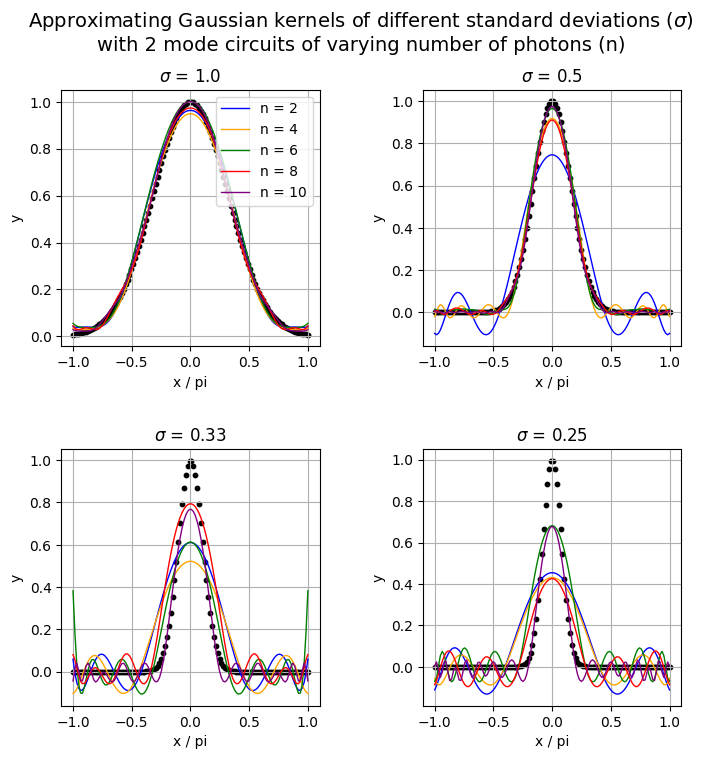

<Figure size 640x480 with 0 Axes>

In [11]:
def visualize_learned_function(results, num_photons, x_on_pi, delta, ys_info):
    """Visualize learned function of different models to compare them with the target function, a Gaussian"""
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    i = 0
    j = 0
    ys = ys_info["ys"]
    y_names = ys_info["names"]
    sigmas = [1.00, 0.50, 0.33, 0.25]
    circuit_names = [f"MZI_{n}" for n in num_photons]

    for y, y_name, sigma in zip(ys, y_names, sigmas):
        axis = axs[i // 2][j % 2]
        y_results = results[f"{y_name}"]["results"]
        y_models = results[f"{y_name}"]["models"]
        for circuit_name, model in zip(circuit_names, y_models):
            model_results = y_results[circuit_name]
            color = model_results["color"]
            model.eval()
            with torch.no_grad():
                output = model(torch.tensor(delta, dtype=torch.float).unsqueeze(-1))
            axis.plot(
                x_on_pi,
                output.detach().numpy(),
                label=f"n = {circuit_name[4:]}",
                color=color,
                linewidth=1,
            )

        axis.scatter(x_on_pi, y, s=10, color="k")

        axis.set_xlabel("x / pi")
        axis.set_ylabel("y")
        axis.grid(True)
        if i == 0 and j == 0:
            axis.legend(loc="upper right")
        axis.title.set_text(f"$\\sigma$ = {sigma}")
        i += 1
        j += 1
    fig.suptitle(
        "Approximating Gaussian kernels of different standard deviations ($\\sigma$)\nwith 2 mode circuits of varying number of photons (n)",
        fontsize=14,
    )
    # plt.savefig("./results/gaussian_kernel_quantum.png")  # To save the figure locally
    plt.show()
    plt.clf()
    return


visualize_learned_function(all_results, num_photons, x_on_pi, delta, ys_info)

This is not as accurate as we would have wanted but we can work with it. For a standard deviation of 1, our models achieve good results but as we decrease its value, the models achieved worse results, especially the ones with fewer photons. Ideally, this is supposed to show that increasing the number of photons also increases the expressivity of the quantum model.

## 6. Application: Using our trained kernel estimators for binary classification

### 6.1 Generate data

Let's generate some 2D datasets for which our trained Gaussian kernel estimator will be useful. Namely, we will work the circle, moon and blob datasets from sklearn.

In [12]:
def get_circle(num_samples, noise=0.1):
    x, y = make_circles(
        n_samples=num_samples,  # number of data points
        noise=noise,
        random_state=42,
    )
    return x, y


def get_moon(num_samples, noise=0.2):
    x, y = make_moons(
        n_samples=num_samples,  # number of data points
        noise=noise,
        random_state=42,
    )
    return x, y


def get_blobs(num_samples, centers=2):
    x, y = make_blobs(
        n_samples=num_samples, centers=centers, cluster_std=4.0, random_state=42
    )
    return x, y


def get_visual_sample(x, y, title):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    axs[0].scatter(x[0][:, 0], x[0][:, 1], c=y[0], cmap="bwr", edgecolor="k")
    axs[0].set_xlabel("x1")
    axs[0].set_ylabel("x2")
    axs[1].scatter(x[1][:, 0], x[1][:, 1], c=y[1], cmap="bwr", edgecolor="k")
    axs[1].set_xlabel("x1")
    axs[1].set_ylabel("x2")
    axs[2].scatter(x[2][:, 0], x[2][:, 1], c=y[2], cmap="bwr", edgecolor="k")
    axs[2].set_xlabel("x1")
    axs[2].set_ylabel("x2")
    axs[0].title.set_text(title[0])
    axs[1].title.set_text(title[1])
    axs[2].title.set_text(title[2])

    # plt.savefig("./results/data_visualization.png")  # To save figure locally
    plt.show()
    plt.clf()
    return

The next step is scaling the data and separating it to train and test sets.

One thing to keep in mind during scaling of the data is that the range of squared distances between points on which we have trained our Gaussian kernel model is $[0, \pi^2]$ since our initial x is defined on $[-\pi, \pi]$ and the distance is computed between x and zero. So it would be ideal if the scaling of our data takes that into account so our model only receives values within its training domain. To do so, we define a scaling factor adjusted to our situation (0.65).

Circular training set: 120 samples, 2 features
Circular test set: 80 samples, 2 features
Moon training set: 120 samples, 2 features
Moon test set: 80 samples, 2 features
Blob training set: 120 samples, 2 features
Blob test set: 80 samples, 2 features


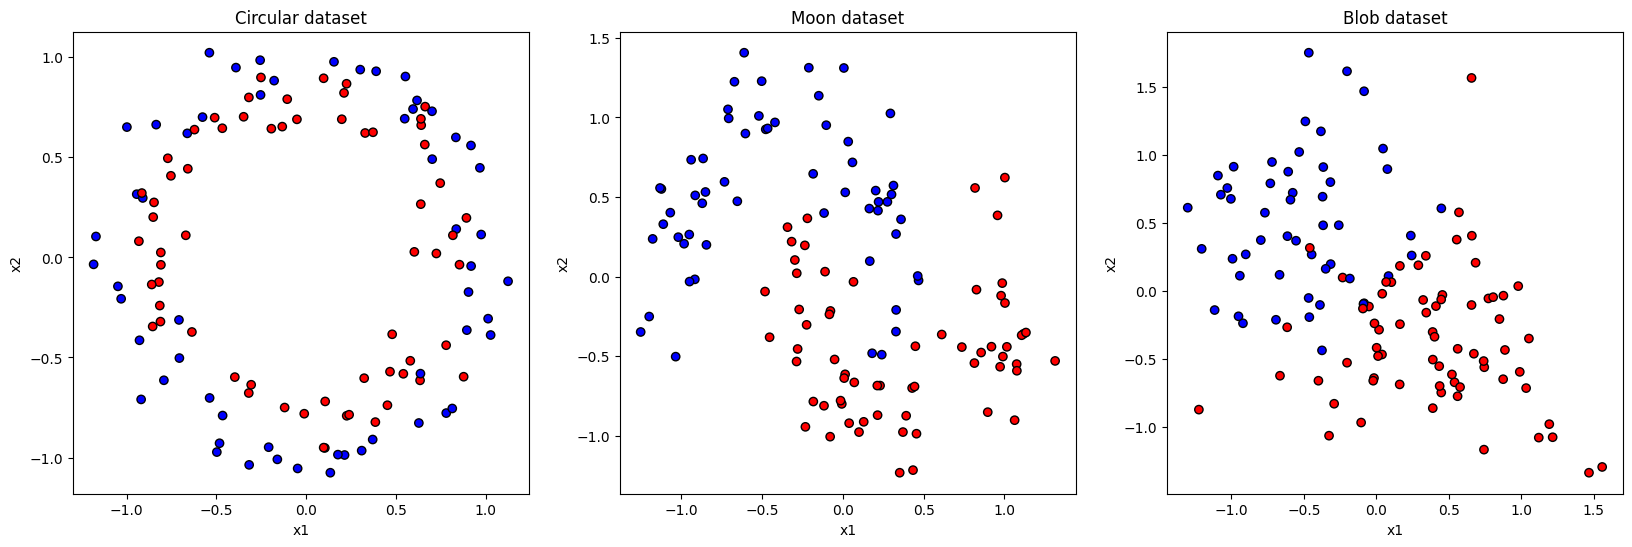

<Figure size 640x480 with 0 Axes>

In [13]:
def prepare_data(scaling_factor=0.65):
    """Standardization, type changing and splitting of the data for preparation"""
    x_circ, y_circ = get_circle(200)
    x_moon, y_moon = get_moon(200)
    x_blob, y_blob = get_blobs(200)

    x_circ_train, x_circ_test, y_circ_train, y_circ_test = train_test_split(
        x_circ, y_circ, test_size=0.4, random_state=42
    )

    # Convert data to PyTorch tensors
    x_circ_train = torch.FloatTensor(x_circ_train)
    y_circ_train = torch.FloatTensor(y_circ_train)
    x_circ_test = torch.FloatTensor(x_circ_test)
    y_circ_test = torch.FloatTensor(y_circ_test)

    scaler = StandardScaler()
    x_circ_train = (
        torch.FloatTensor(scaler.fit_transform(x_circ_train)) * scaling_factor
    )
    x_circ_test = torch.FloatTensor(scaler.transform(x_circ_test)) * scaling_factor

    print(
        f"Circular training set: {x_circ_train.shape[0]} samples, {x_circ_train.shape[1]} features"
    )
    print(
        f"Circular test set: {x_circ_test.shape[0]} samples, {x_circ_test.shape[1]} features"
    )

    x_moon_train, x_moon_test, y_moon_train, y_moon_test = train_test_split(
        x_moon, y_moon, test_size=0.4, random_state=42
    )

    # Convert data to PyTorch tensors
    x_moon_train = torch.FloatTensor(x_moon_train)
    y_moon_train = torch.FloatTensor(y_moon_train)
    x_moon_test = torch.FloatTensor(x_moon_test)
    y_moon_test = torch.FloatTensor(y_moon_test)

    scaler = StandardScaler()
    x_moon_train = (
        torch.FloatTensor(scaler.fit_transform(x_moon_train)) * scaling_factor
    )
    x_moon_test = torch.FloatTensor(scaler.transform(x_moon_test)) * scaling_factor

    print(
        f"Moon training set: {x_moon_train.shape[0]} samples, {x_moon_train.shape[1]} features"
    )
    print(
        f"Moon test set: {x_moon_test.shape[0]} samples, {x_moon_test.shape[1]} features"
    )

    x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(
        x_blob, y_blob, test_size=0.4, random_state=42
    )

    # Convert data to PyTorch tensors
    x_blob_train = torch.FloatTensor(x_blob_train)
    y_blob_train = torch.FloatTensor(y_blob_train)
    x_blob_test = torch.FloatTensor(x_blob_test)
    y_blob_test = torch.FloatTensor(y_blob_test)

    scaler = StandardScaler()
    x_blob_train = (
        torch.FloatTensor(scaler.fit_transform(x_blob_train)) * scaling_factor
    )
    x_blob_test = torch.FloatTensor(scaler.transform(x_blob_test)) * scaling_factor

    print(
        f"Blob training set: {x_blob_train.shape[0]} samples, {x_blob_train.shape[1]} features"
    )
    print(
        f"Blob test set: {x_blob_test.shape[0]} samples, {x_blob_test.shape[1]} features"
    )

    x_train = [x_circ_train, x_moon_train, x_blob_train]
    x_test = [x_circ_test, x_moon_test, x_blob_test]
    y_train = [y_circ_train, y_moon_train, y_blob_train]
    y_test = [y_circ_test, y_moon_test, y_blob_test]

    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = prepare_data()
# Visualize training data
get_visual_sample(
    x_train, y_train, title=["Circular dataset", "Moon dataset", "Blob dataset"]
)

### 6.2 Compute kernel value for every pair of data points using our quantum model

To do so, we first need the delta (squared Euclidean distance) between each pair of points.

In [14]:
def calculate_delta(x1, x2):
    """
    Computes squared Euclidean distances between each pair of vectors in x1 and x2.
    x1: Tensor of shape (n1, d)
    x2: Tensor of shape (n2, d)
    Returns: Tensor of shape (n1, n2) with delta[i, j] = ||x1[i] - x2[j]||^2
    """
    # Ensure 2D input
    assert x1.ndim == 2 and x2.ndim == 2, "Inputs must be 2D tensors"

    # Use broadcasting to compute pairwise squared Euclidean distances
    diff = x1[:, None, :] - x2[None, :, :]  # shape (n1, n2, d)
    delta = torch.sum(diff**2, dim=2)  # shape (n1, n2)

    # Optional sanity checks
    assert delta.shape[0] == x1.size(0), "First dimension of delta is off"
    assert delta.shape[1] == x2.size(0), "Second dimension of delta is off"

    return delta

Calculate the kernel value with our previously defined quantum model.

In [15]:
def get_kernel(model, delta):
    """
    Efficiently apply `model` to each element in the `delta` matrix.
    Assumes model maps a scalar input to a scalar output.
    """
    model.eval()
    with torch.no_grad():
        flat_input = delta.view(-1, 1)  # shape (n1 * n2, 1)
        output = model(flat_input)  # shape (n1 * n2, 1) or (n1 * n2,)
        kernel_matrix = output.view(delta.shape)
    return kernel_matrix

### 6.3 Define the training for a SVM for classification

In the first function, we define the training for a SVM utilizing the quantum Gaussian kernel sampler.

In [16]:
def train_q_svm(k_train, k_test, y_train, y_test):
    clf = SVC(kernel="precomputed")
    clf.fit(k_train.numpy(), y_train.numpy())

    y_pred = clf.predict(k_test.numpy())
    accuracy = accuracy_score(y_test.numpy(), y_pred)
    return accuracy

In the second, we define the training for a classical rbf SVM.

In [17]:
def train_classical_svm(x_train, x_test, y_train, y_test, sigma):
    gamma = 1 / (2 * sigma**2)
    clf = SVC(kernel="rbf", gamma=gamma)
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    acc = accuracy_score(y_test, preds)
    return acc

### 6.4 Define the classification training for the q_SVM and the classical SVM.

In [18]:
def classif_training(kernel="quantum"):
    accs = {
        "circular_acc": [],
        "moon_acc": [],
        "blob_acc": [],
        "std_name": [],
        "n_photons": [],
    }
    std_names = ys_info["names"]

    if kernel == "quantum":
        for std_name in std_names:
            for i in range(5):
                n_photons = (i + 1) * 2
                model = all_results[std_name]["models"][i]

                # Calculate delta
                delta_train_circ = calculate_delta(x_train[0], x_train[0])
                delta_test_circ = calculate_delta(x_test[0], x_train[0])
                delta_train_moon = calculate_delta(x_train[1], x_train[1])
                delta_test_moon = calculate_delta(x_test[1], x_train[1])
                delta_train_blob = calculate_delta(x_train[2], x_train[2])
                delta_test_blob = calculate_delta(x_test[2], x_train[2])

                # Calculate kernel
                kernel_train_circ = get_kernel(model, delta_train_circ)
                kernel_test_circ = get_kernel(model, delta_test_circ)
                kernel_train_moon = get_kernel(model, delta_train_moon)
                kernel_test_moon = get_kernel(model, delta_test_moon)
                kernel_train_blob = get_kernel(model, delta_train_blob)
                kernel_test_blob = get_kernel(model, delta_test_blob)

                # Train SVM
                circular_acc = train_q_svm(
                    kernel_train_circ, kernel_test_circ, y_train[0], y_test[0]
                )
                moon_acc = train_q_svm(
                    kernel_train_moon, kernel_test_moon, y_train[1], y_test[1]
                )
                blob_acc = train_q_svm(
                    kernel_train_blob, kernel_test_blob, y_train[2], y_test[2]
                )

                accs["circular_acc"].append(circular_acc)
                accs["moon_acc"].append(moon_acc)
                accs["blob_acc"].append(blob_acc)
                accs["std_name"].append(std_name)
                accs["n_photons"].append(n_photons)
    elif kernel == "rbf":
        for std_name in std_names:
            std = float(std_name[-4:])
            circular_acc = train_classical_svm(
                x_train[0], x_test[0], y_train[0], y_test[0], std
            )
            moon_acc = train_classical_svm(
                x_train[1], x_test[1], y_train[1], y_test[1], std
            )
            blob_acc = train_classical_svm(
                x_train[2], x_test[2], y_train[2], y_test[2], std
            )

            accs["circular_acc"].append(circular_acc)
            accs["moon_acc"].append(moon_acc)
            accs["blob_acc"].append(blob_acc)
            accs["std_name"].append(std_name)
            accs["n_photons"].append(-1)
    else:
        raise ValueError(f"Unknown kernel type: {kernel}")
    return accs

### 6.5 Run the training for both SVMs and compare the obtained accuracies

In [19]:
q_accs = classif_training("quantum")
classical_accs = classif_training("rbf")

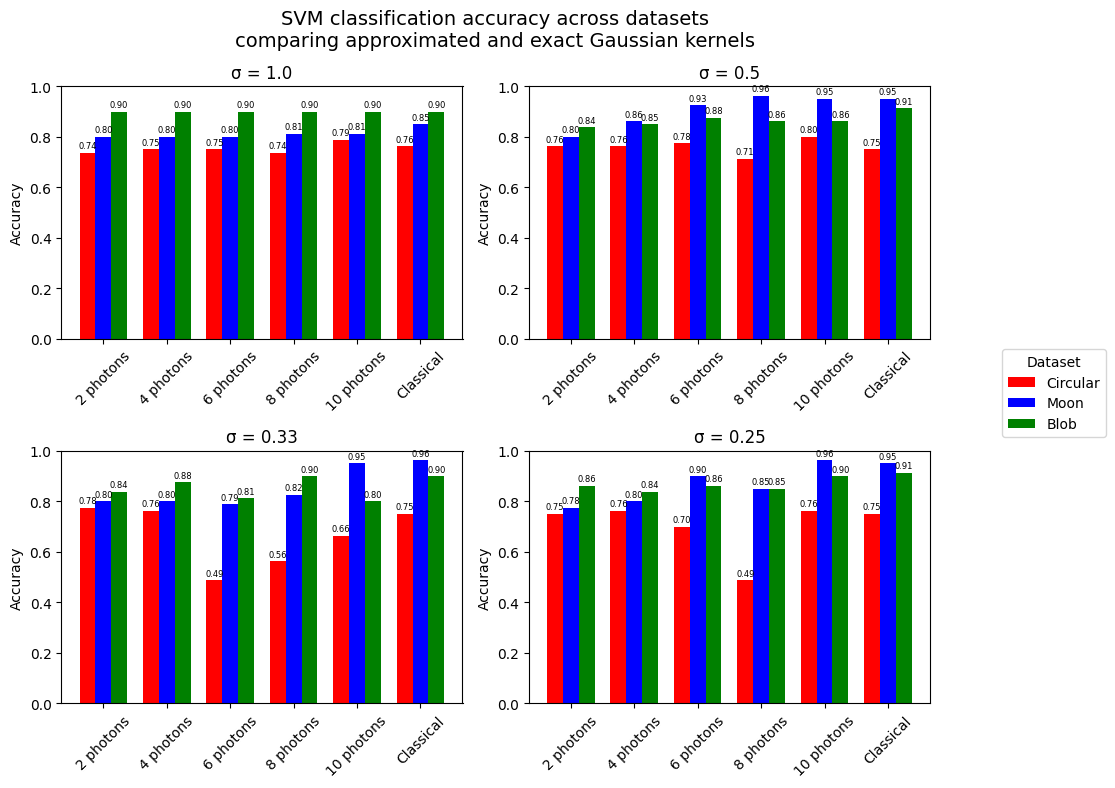

<Figure size 640x480 with 0 Axes>

In [20]:
def visualize_accuracies(q_results, classical_results):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # Map each std to a subplot index
    std_to_pos = {1.0: (0, 0), 0.5: (0, 1), 0.33: (1, 0), 0.25: (1, 1)}

    datasets = ["circular", "moon", "blob"]
    quantum_colors = ["red", "blue", "green"]

    unique_stds = sorted(set(q_results["std_name"]), reverse=True)  # just in case

    for std in unique_stds:
        std_str = std
        std = float(std[6:])
        if std not in std_to_pos:
            print(f"std skipped: {std}")
            continue  # skip stds not in layout
        axis = axs[std_to_pos[std]]

        # Get quantum data for this std
        std_indices = [j for j, s in enumerate(q_results["std_name"]) if s == std_str]
        n_photon_vals = sorted({q_results["n_photons"][j] for j in std_indices})

        num_groups = len(n_photon_vals) + 1  # +1 for classical comparison
        positions = np.arange(num_groups)

        for k, dataset in enumerate(datasets):
            y_vals = []
            for n in n_photon_vals:
                idx = next(j for j in std_indices if q_results["n_photons"][j] == n)
                y = q_results[f"{dataset}_acc"][idx]
                y_vals.append(y)

            classical_idx = classical_results["std_name"].index(std_str)
            classical_y = classical_results[f"{dataset}_acc"][classical_idx]
            y_vals.append(classical_y)

            x_pos = positions + k * 0.25
            for j, y in enumerate(y_vals):
                if j < len(n_photon_vals):
                    # Quantum bar
                    axis.bar(x_pos[j], y, width=0.25, color=quantum_colors[k])
                else:
                    # Classical bar
                    axis.bar(
                        x_pos[j],
                        y,
                        width=0.25,
                        color=quantum_colors[k],
                    )
                # Add text above each bar
                axis.text(
                    x_pos[j], y + 0.01, f"{y:.2f}", ha="center", va="bottom", fontsize=6
                )

        x_labels = [str(n) + " photons" for n in n_photon_vals] + ["Classical"]
        tick_positions = positions + 0.25
        axis.set_xticks(tick_positions)
        axis.set_xticklabels(x_labels, rotation=45)
        axis.set_title(f"σ = {std}")
        axis.set_ylabel("Accuracy")
        axis.set_ylim(0, 1)

    plt.suptitle(
        "SVM classification accuracy across datasets\ncomparing approximated and exact Gaussian kernels",
        fontsize=14,
    )
    handles, labels = axs[0, 0].get_legend_handles_labels()
    legend_patches = [
        Patch(facecolor=quantum_colors[i], label=datasets[i].capitalize())
        for i in range(len(datasets))
    ]

    fig.legend(
        handles=legend_patches,
        loc="center left",
        bbox_to_anchor=(1.0, 0.5),
        title="Dataset",
    )

    plt.tight_layout(rect=[0, 0, 0.95, 1])
    # plt.savefig("./results/svm_accuracies_quantum_kernel.png", bbox_inches='tight', dpi=600)  # To save locally
    plt.show()
    plt.clf()
    return


visualize_accuracies(q_accs, classical_accs)

So even if the Gaussian kernel fits were not as accurate as we wanted, we can see that the quantum Gaussian kernel samplers are as accurate as the classical rbf SVM for the most part. Namely, the quantum approximators that used more photons tend to reach better results. However, is this methodology really bringing something interesting ? Because in the end we are approximating a classical function for which the calculation is highly optimized and using a quantum circuit to approximate does not bring any real advantage in this context.